In [1]:
## Importações de bibliotecas
import os
import cv2
import PIL
import numpy as np
import scipy
import skimage.io as io
import matplotlib.pyplot as plt

from PIL import Image
from skimage import data
from scipy import fftpack
from collections import Counter
#Funções

In [2]:
## Funções de transformadas
JPEG_M = np.matrix([
                [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]
])

JPEG_M = JPEG_M.astype(float)
def dct_more_quantization(image, gs = 8, value = 1):
    """
        Com a matriz de pixels da imagem, aplica a redução numérica de 128, a transformada discreta
        do cosseno e, no final, a divisão da matriz de quantização utilizada pelo JPEG, para valorizar
        os coeficientes de frequência baixa
    """

    n = np.size(image,0)
    m = np.size(image,1)

    matrix = np.zeros((n, m), dtype=float)

    image = image - 128

    for i in range(0, n, gs):
        for j in range(0, m, gs):
            # Aplicando a DCT nas duas dimensões da imagem
            matrix[i:i+gs, j:j+gs] = fftpack.dct(fftpack.dct(image[i:i+gs, j:j+gs], axis=0, norm='ortho'), axis=1, norm="ortho")

            # Aplicando a quantização, dividindo a matriz resultante da DCT pela da JPEG
            v = matrix[i, j]
            matrix[i:i+gs, j:j+gs] = np.round(np.divide(matrix[i:i+gs, j:j+gs], JPEG_M*value))
            matrix[i, j] = v

    # Retorna uma matriz de inteiros, para uso futuro no Huffman
    return np.int16(matrix)
def inverse_dct(dct_matrix, groupSize = 8, value = 1):
    """
        Com a matriz quantizada da DCT, aplica a multiplicação da matriz JPEG, a inversa da
        transformada discreta do cosseno e, no final, soma novamente os 128 que foram reduzidos
        no início da compressão.
    """
    n = np.size(dct_matrix,0)
    m = np.size(dct_matrix,1)

    matrix = np.zeros((n, m), dtype=float)

    for i in range(0, n, groupSize):
        for j in range(0, m, groupSize):
            # Voltando as valores "originais" da transformada, multiplicando pela matriz JPEG
            v = dct_matrix[i, j]
            matrix[i:i+groupSize, j:j+groupSize] = np.multiply(dct_matrix[i:i+groupSize, j:j+groupSize], JPEG_M*value)
            matrix[i, j] = v

            # Aplicando a inversa da DCT nas duas dimensões da imagem
            matrix[i:i+groupSize, j:j+groupSize] = fftpack.idct(fftpack.idct(matrix[i:i+groupSize, j:j+groupSize], axis=0, norm='ortho'), axis=1, norm="ortho")

    # Volta com a adição numérica de 128, que foi retirada na função de DCT
    return np.int16(matrix + 128)

In [6]:
# Definição de parâmetros
group_size = 8
value = 1

pred = False
huff = False

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

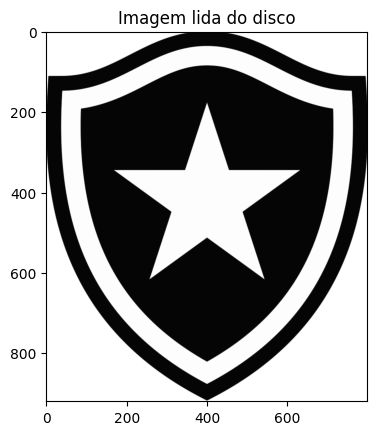

In [9]:
# Importando imagem

# Defina o caminho da imagem aqui.
image_filename = "Escudo_Botafogo.pgm"
image = Image.open(image_filename).convert("L")

#plt.imsave(image_filename, image, cmap='gray')

# Forma de leitura direta com imagem salva do skleark
# image = data.camera()
# image = np.array(image).astype(float)
# plt.imsave('camera.png', image, cmap='gray')
# image_filename = 'camera.png'

if image.size[0] % 8 != 0 or image.size[1] % 8 != 0:
    new_w = image.size[1] - image.size[1] % 8
    new_h =image.size[0] - image.size[0] % 8
    image = image.resize((new_h,new_w))
    # raise Exception("A matriz deve ser múltipla de 8 nas duas dimensões.")

image = np.array(image).astype(float)

# Imprimindo a imagem
plt.imshow(image, cmap='gray')
plt.title("Imagem lida do disco")
plt.show()

In [36]:
# Aplicando transformadas
quantized_image = dct_more_quantization(image, group_size,value) if not huff else np.int16(image)

# Essa decompressão direta servirá de controle para verificar a eficácia da compressão
# do arquivo binário
direct_decompress_image = np.abs(inverse_dct(quantized_image, group_size,value)) if not huff else np.int16(image)
c = direct_decompress_image
c = c.clip(0, 255)